In [1]:
# adapted from https://github.com/yunjey/show-attend-and-tell/blob/master/evaluate_model.ipynb
import torch
import torch.nn as nn
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
from torch.autograd import Variable
from feat_data_loader import *
from extract_feature import get_transform
from models import Decoder, EncoderVGG
from helper import *
import pickle
from build_vocab import *
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 12.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'



In [2]:
transform = get_transform()
name = 'train'
train_table      = pd.read_pickle(os.path.join('.','{}_table.pkl'.format(name)))	
train_captions   = train_table.caption
captions   = [caption for caption in train_captions]
name          = 'val'
val_table     = pd.read_pickle(os.path.join('.','{}_table.pkl'.format(name)))	
val_captions   = val_table.caption
val_captions   = [caption for caption in val_captions]
captions.extend(val_captions)
vocab = build_vocab(captions, threshold=0)

In [3]:

model_path = 'models/vgg_model.pth' # the vgg16 net that only have layers of [0~28] in feature module
encoder_path = 'checkpoints/attn_model.pth' # the trained model


In [4]:
encoder = EncoderVGG(model_path)
decoder = torch.load(encoder_path)
encoder = encoder.cuda()
encoder.eval()
decoder = decoder.cuda()
decoder.eval()

Decoder(
  (embed): Embedding(155, 512)
  (dropout): Dropout(p=0.8)
  (lstm_cell): LSTMCell(1024, 512, bias=1)
  (fc_dropout): Dropout(p=0.8)
  (fc_out): Linear(in_features=512, out_features=155, bias=True)
  (att_vw): Linear(in_features=512, out_features=512, bias=False)
  (att_hw): Linear(in_features=512, out_features=512, bias=False)
  (att_w): Linear(in_features=512, out_features=1, bias=False)
)

In [5]:
import data_loader_openi as dl
def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)
feature_path='data/feat_openi.pth'
batch_size = 1
shuffle = True
num_workers = 2
transform = get_transform()

dataloader = dl.get_loader(vocab, 
                        feature_path= feature_path, 
                        batch_size = batch_size,
                        shuffle=True, 
                        num_workers=num_workers, 
                        name='train', 
                        transform=transform)
names = []
captions = []
alphas = []
for i, (features, targets, lengths) in enumerate(dataloader):
    #image = Variable(image).cuda()
    #fea = encoder(image)
    #fea = fea.view(fea.size(0), 512, 196).transpose(1, 2)
    fea = to_var(features).transpose(1,2)
    ids, weights = decoder.sample(fea)
    names.append(name)
    captions.append(ids)
    alphas.append(weights)
    if (i+1)%20 == 0:
        break

/home/ubuntu/Lung-Disease-Detection-Project/models.py:281: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = nn.Softmax()(att_out)


['normal', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']


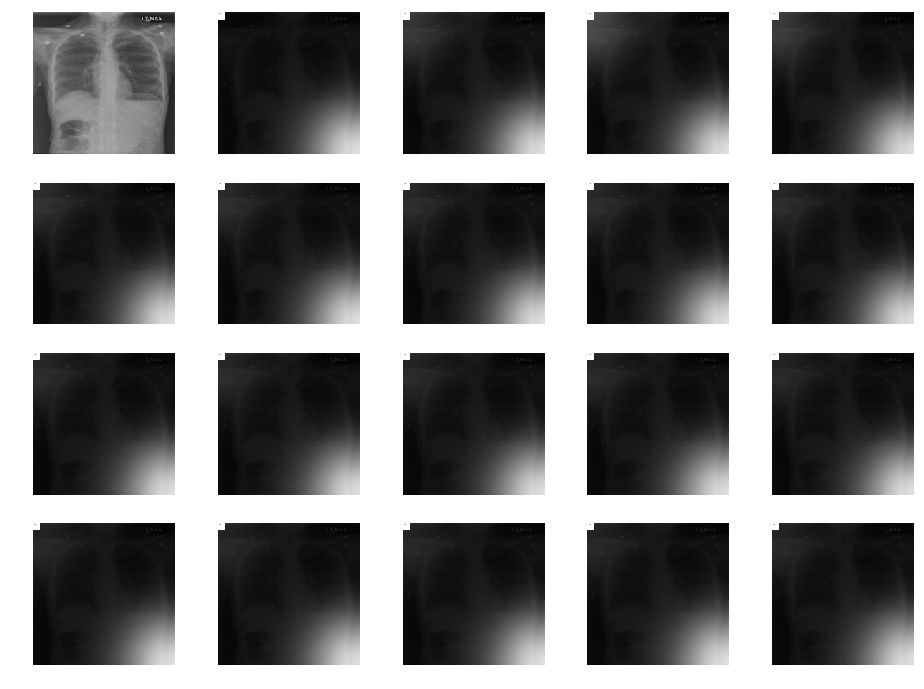

In [24]:
idx  = 19
alps = torch.cat(alphas[idx][1:], 0)

cap = decode_captions(captions[idx].data.cpu().view(1, -1), vocab.idx2word)[0]
print(cap)
root = 'data/images'
attention_visualization(root, 'CXR1997_IM-0651-1001.png', cap, alps.data.cpu())
idx += 1